# PINN - SIRD

A SIR model is a model describing how the number of susceptible, infected and recovered persons co-vary.


The equations determing the realtionsship between these number are:

$$
\frac{ds}{dt} = \frac{-b s(t) i(t)}{N}  \\
$$
$$
\frac{di}{dt} = \frac{bs(t)i(t)}{N} -(k + m) i(t) \\
$$
$$
\frac{dr}{dt} = ki(t)
$$

$$
\frac{dd}{dt} = m i(t)
$$

In this notebook I will try to solve a SIR disease model first using an ordinary differential equation solver, than using a PINN.


In [190]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

Define parameters:

In [238]:
T = 300
num_samples = 500
num_boundary = 2

k = 1/200
b = 1/20
m = 1/700

Now define the initial values:

In [239]:
N = 10 # Total population
I0 = 1
R0 = 0
D0 = 0
S0 = N - I0 - R0

By changing into fractions the initial conditions becomes:

## Using ODE solver:

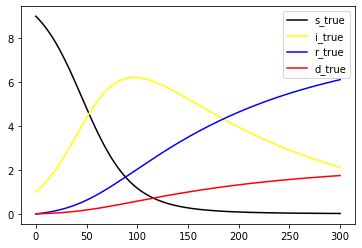

In [240]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Defining the derivatives of the equation.
def derivatives(y, t, N, b, k, m):
    s, i, r, d = y
    ds_dt = - b * s * i / N
    di_dt = b * s * i / N - (k + m) * i
    dr_dt = k * i
    dd_dt = m * i 
    return ds_dt, di_dt, dr_dt, dd_dt

t = np.linspace(0, T, num_samples)

y0 = S0, I0, R0, D0

# Solve equation:
sol = integrate.odeint(derivatives, y0, t, args= (N, b, k, m))
s_true, i_true, r_true, d_true = sol.T
s_true = s_true.reshape(-1, 1)
i_true = i_true.reshape(-1, 1)
r_true = r_true.reshape(-1, 1)
d_true = d_true.reshape(-1, 1)
plt.plot(t, s_true, color="black"), plt.plot(t, i_true, color="yellow"),
plt.plot(t, r_true, color="blue"), plt.plot(t, d_true, color= "red")
plt.legend(["s_true", "i_true", "r_true", "d_true"])

Now define the ODE system:


In [241]:
def ode_system(x, y):
    s = y[:, 0:1]
    i = y[:, 1:2]
    r = y[:, 2:3]
    d = y[:, 3:4]
    ds_dt = dde.grad.jacobian(y, x, i= 0)
    di_dt = dde.grad.jacobian(y, x, i= 1)
    dr_dt = dde.grad.jacobian(y, x, i= 2)
    dd_dt = dde.grad.jacobian(y, x, i= 3)

    return [
    ds_dt + b * s * i / N,
    di_dt - b * s * i / N + k * i,
    dr_dt - k,
    dd_dt - m * i
    ]

In [242]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, T)

# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial

# Specify the intial values:
ic_s = dde.IC(geom, lambda X: S0, boundary, component= 0)
ic_i = dde.IC(geom, lambda X: I0, boundary, component= 1)
ic_r = dde.IC(geom, lambda X: R0, boundary, component= 2)
ic_d = dde.IC(geom, lambda X: D0, boundary, component= 3)

In [243]:
# Create the equation:
data = dde.data.PDE(geom, ode_system, [ic_s, ic_i, ic_r, ic_d], num_samples, num_boundary, num_test=1000)

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn("The balance properties of Sobol' points require "


In [244]:
# Define and create the neural network:
layer_size = [1] + [64] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

In [245]:
# Combine the data and network into a model:
model = dde.Model(data, net)

In [246]:
# Training:
#model.compile("adam", lr=0.001)
#losshistory, train_state = model.train(epochs=10000)

#model.compile("adam", lr=0.0001, loss_weights= [10, 10, 10, 10, 1, 1, 1, 1])
#losshistory, train_state = model.train(epochs=5000)

#model.compile("adam", lr=0.0001, loss_weights= [1, 1, 1, 1, 1, 1, 1, 1])
#losshistory, train_state = model.train(epochs=5000)

model.compile("adam", lr=0.00001, loss_weights= [1, 1, 1, 1, 1, 1, 1, 1])
losshistory, train_state = model.train(epochs=30000)

#model.compile("L-BFGS")
#losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.102930 s



/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-01 10:19:48.054208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-01 10:19:48.054441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 wit

'compile' took 1.139597 s

Initializing variables...


2021-12-01 10:19:51.610300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...



2021-12-01 10:19:52.458205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [4.69e-04, 5.06e-04, 2.44e-04, 7.23e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00]    [4.81e-04, 5.17e-04, 2.38e-04, 7.22e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00]    []  


2021-12-01 10:19:53.392952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000      [3.78e-03, 7.40e-05, 1.74e-04, 6.64e-05, 6.58e+01, 5.54e-01, 3.50e-11, 1.43e-05]    [3.96e-03, 6.65e-05, 1.69e-04, 6.33e-05, 6.58e+01, 5.54e-01, 3.50e-11, 1.43e-05]    []  
2000      [5.01e-03, 1.84e-04, 1.13e-04, 3.98e-05, 3.12e+01, 2.68e-03, 1.16e-08, 3.39e-08]    [5.07e-03, 1.39e-04, 1.09e-04, 3.21e-05, 3.12e+01, 2.68e-03, 1.16e-08, 3.39e-08]    []  
3000      [1.71e-03, 1.57e-04, 6.10e-05, 2.54e-05, 7.49e+00, 6.85e-02, 4.19e-10, 4.86e-09]    [1.56e-03, 1.25e-04, 5.81e-05, 2.02e-05, 7.49e+00, 6.85e-02, 4.19e-10, 4.86e-09]    []  
4000      [7.02e-04, 2.87e-04, 3.20e-05, 1.63e-05, 8.74e-01, 1.08e-02, 8.90e-11, 5.82e-10]    [5.16e-04, 2.77e-04, 3.04e-05, 1.36e-05, 8.74e-01, 1.08e-02, 8.90e-11, 5.82e-10]    []  
5000      [5.14e-04, 3.59e-04, 2.50e-05, 1.17e-05, 3.32e-02, 2.42e-04, 2.55e-11, 1.13e-10]    [3.42e-04, 3.55e-04, 2.40e-05, 1.01e-05, 3.32e-02, 2.42e-04, 2.55e-11, 1.13e-10]    []  
6000      [4.34e-04, 3.76e-04, 2.27e-05, 9.80e-06, 1.63e-04, 5.89e-07, 1.88e-11, 6.09

Saving loss history to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/loss.dat ...
Saving training data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/train.dat ...
Saving test data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/test.dat ...


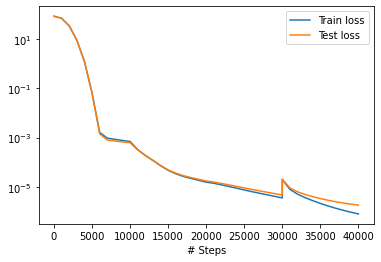

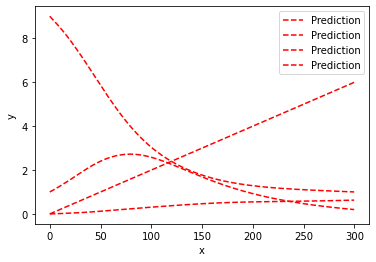

In [233]:
# Plot and save
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

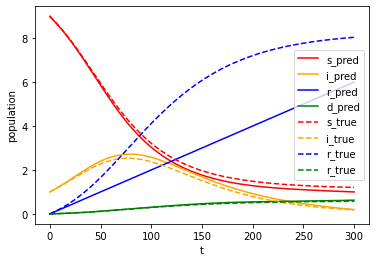

In [234]:
t = np.reshape(np.linspace(0, T, num_samples), (-1, 1))
sol_pred = model.predict(t)
s_pred = sol_pred[:, 0:1]
i_pred = sol_pred[:, 1:2]
r_pred =sol_pred[:, 2:3]
d_pred = sol_pred[:, 3:4]


plt.xlabel("t")
plt.ylabel("population")
plt.plot(t, s_pred, color="red", label="s_pred")
plt.plot(t, i_pred, color="orange", label="i_pred")
plt.plot(t, r_pred, color="blue", label="r_pred")
plt.plot(t, d_pred, color="green", label="d_pred")
plt.plot(t, s_true, color="red", label="s_true", linestyle="dashed")
plt.plot(t, i_true, color="orange", label="i_true", linestyle="dashed")
plt.plot(t, r_true, color="blue", label="r_true", linestyle="dashed")
plt.plot(t, d_true, color="green", label="r_true", linestyle="dashed")
plt.legend()
plt.show()